# Statistical analysis of HDX/MS data for curated LacI peptides in one or more functional states.

### First choose the state(s).

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pytraj as pt
import nglview as nv
from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import seaborn as sns
import ipywidgets as widgets
from scipy.optimize import curve_fit
from matplotlib.ticker import FormatStrFormatter


print('Choose from the following functional states: ')
CBwidget_IPTG = widgets.Checkbox(description = 'IPTG, an inducer molecule', value=True, disabled=False)
CBwidget_ONPF = widgets.Checkbox(description = 'ONPF, an anti-inducer molecule', value=True, disabled=False)
CBwidget_APO = widgets.Checkbox(description = 'APO protein', value=False, disabled=False)
CBwidget_DNA = widgets.Checkbox(description = 'operator DNA', value=True, disabled=False)
CBwidget_TMG = widgets.Checkbox(description = 'TMG, an inducer molecule', value=False, disabled=False)
CBwidget_ONPFDNA = widgets.Checkbox(description = 'ONPF and operator DNA', value=False, disabled=False)

display(CBwidget_IPTG, CBwidget_ONPF, CBwidget_APO, CBwidget_DNA, CBwidget_TMG, CBwidget_ONPFDNA)

Choose from the following functional states: 


Checkbox(value=True, description='IPTG, an inducer molecule')

Checkbox(value=True, description='ONPF, an anti-inducer molecule')

Checkbox(value=False, description='APO protein')

Checkbox(value=True, description='operator DNA')

Checkbox(value=False, description='TMG, an inducer molecule')

Checkbox(value=False, description='ONPF and operator DNA')

In [3]:
states_list = []

if CBwidget_IPTG.value == True:
    states_list.append('IPTG')
if CBwidget_ONPF.value == True:
    states_list.append('ONPF')
if CBwidget_APO.value == True:
    states_list.append('APO')
if CBwidget_DNA.value == True:
    states_list.append('DNA')
if CBwidget_TMG.value == True:
    states_list.append('TMG')
if CBwidget_ONPFDNA.value == True:
    states_list.append('ONPFDNA')

print('Chosen states:'); print(*states_list)

res_peptides_file = pd.ExcelFile('peptide_list.xlsx')

states_dict = {}
peptide_states_list = ['peptide']
for state in states_list:
    states_dict[state] = pd.read_excel(res_peptides_file)
    peptide_states_list.append(state)
        
single_state_dict = states_dict.get(states_list[0])
all_peptides = single_state_dict[['peptide']].values.tolist()
all_peptides_2 = []
first_res = single_state_dict[['first_res']].values.tolist()
index = 0

while index < len(all_peptides):
    current_first_res = str(int(first_res[index][0]))
    all_peptides_2.append(current_first_res + ' - ' + all_peptides[index][0])
    index = index + 1

Chosen states:
IPTG ONPF APO DNA TMG ONPFDNA


### Compile exchange information for each peptide for chosen states.

In [225]:
############

def getIndexes(dfObj, value):
    listOfPos = []
    result = dfObj.isin([value])
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row, col))
    return listOfPos

############

# create dictionary keys from peptides
# in subsequent code: add state and each TP avg exchange measurements as values for peptide keys
peptide_exchange_dict = {}
for peptide in all_peptides:
    peptide_exchange_dict[peptide[0]] = []

for state in states_dict:
    i = 0 # peptide counter
    for peptide in states_dict[state]['peptide']:
        peptide_first_res = states_dict[state]['first_res'][i]
        peptide_last_res = states_dict[state]['last_res'][i]

        peptide_file = pd.ExcelFile('~/Dropbox/Research/Data/HDX/20200816/20200819_fitting/' + str(peptide_first_res)
                                    + '_' + str(peptide_last_res) + '_' + peptide + '_fitting.xlsx')
        raw_df = pd.read_excel(peptide_file, 'Peptide SD', nrows = 15)
        
        column_vals = []
        listOfPositions = getIndexes(raw_df, state)
        for j in range(len(listOfPositions)):
            temp_string = (listOfPositions[j][1])
            position = int(temp_string[-2:])
            column_vals.append(position) # columns in spreadsheet corresponding to data label

        peptide_exchange = {}
        for element in column_vals:
            if state.lower() == (raw_df.iloc[2][element]).lower():
                peptide_exchange[state] = list(raw_df.iloc[4:13,element+2])
        
        peptide_exchange_dict[peptide].append(peptide_exchange)
        
        i = i + 1

In [ ]:
stdev_dict_IPTG = {}
stdev_dict_ONPF = {}
stdev_dict_APO = {}
stdev_dict_DNA = {}
stdev_dict_ONPFDNA = {}
stdev_dict_TMG = {}
stdev_dict_list = [stdev_dict_IPTG,stdev_dict_ONPF,stdev_dict_APO,stdev_dict_DNA,stdev_dict_ONPFDNA,stdev_dict_TMG]

for state in states_dict:
    i = 0
    for peptide in states_dict[state]['peptide']:

        peptide_first_res = states_dict[state]['first_res'][i]
        peptide_last_res = states_dict[state]['last_res'][i]

        peptide_file = pd.ExcelFile('~/Dropbox/Research/Data/HDX/20200816/20200819_fitting/' + str(peptide_first_res)
                                    + '_' + str(peptide_last_res) + '_' + peptide + '_fitting.xlsx')
        stdev_df = pd.read_excel(peptide_file, 'Peptide SD', usecols = "H,P,Y,AH,AP,AX", 
                                 skiprows = 26, nrows = 35, header = None)
        stdev_df = stdev_df[0:9]
        
        stdev_dict_IPTG[peptide] = list(stdev_df.iloc[:, 0])
        stdev_dict_ONPF[peptide] = list(stdev_df.iloc[:, 1])        
        stdev_dict_APO[peptide] = list(stdev_df.iloc[:, 2])
        stdev_dict_DNA[peptide] = list(stdev_df.iloc[:, 3])
        stdev_dict_ONPFDNA[peptide] = list(stdev_df.iloc[:, 4])
        stdev_dict_TMG[peptide] = list(stdev_df.iloc[:, 5])
        
        i = i + 1

### Plot H/D exchange functions as uptake plots for each peptide for each state.

In [226]:
# fitting

def exchange_fit(x, a, b, c, d, e, f, g):
    max_protons = a + b + c + g - 2 - num_prolines
    d > e
    e > f
    d > f
    return max_protons - a * np.exp(-d * x) - b * np.exp(-e * x) - c * np.exp(-f * x) - g

def exchange_fit_low(x, b, c, e, f, g):
    max_protons = b + c + g - 2 - num_prolines
    e > f
    return max_protons - b * np.exp(-e * x) - c * np.exp(-f * x) - g

timepoints = [0, 30, 45, 60, 300, 1500, 3600, 7200, 14400]
trialT = np.logspace(1.5, 4.5, 10000)


# create dictionary keys from peptides
# in subsequent code: add state and FITS (long vectors) as values for peptide keys (peptide_fit_dict)
# add state and popt curvefit PARAMS for peptide keys (peptide_params_dict)

peptide_fit_dict = {}
peptide_params_dict = {}
for peptide in all_peptides:
    peptide_fit_dict[peptide[0]] = []
    peptide_params_dict[peptide[0]] = []

for peptide in peptide_exchange_dict:

    num_prolines = peptide[2:].count('P')
    max_protons = len(peptide) - 2 - num_prolines
    
    for element in peptide_exchange_dict.get(peptide): # element is state
        [exchange_list] = element.values() # these are the avg tp measurements for the state
        
        for state in element.keys():

            # create sub-dictionaries that links state (key) to fits or params (values),
            # then add sub-dicts as values to peptide_fit_dict or peptide_params_dict
            
            sub_fit_dict = {}
            sub_params_dict = {}
            
            p1_index = 0
            peptide1_tps = []
            peptide1_ex = []
            for tp in exchange_list:
                if not math.isnan(float(tp)):
                    peptide1_tps.append(timepoints[p1_index])
                    peptide1_ex.append(float(tp))
                p1_index = p1_index + 1

            if peptide1_ex[-1] > .5:

                popt, pcov = curve_fit(f = exchange_fit, xdata = peptide1_tps, ydata = peptide1_ex,
                                       bounds = (0, [max_protons, max_protons, max_protons, 1, .1, .01, max_protons]),
                                       maxfev = 100000)
                exchange_peptide1 = exchange_fit(trialT, *popt)
                perr = np.sqrt(np.diag(pcov))

            else:

                popt, pcov = curve_fit(f = exchange_fit_low, xdata = peptide1_tps, ydata = peptide1_ex,
                                       bounds = (0, [max_protons, max_protons, .1, .01, max_protons]),
                                       maxfev = 100000)
                exchange_peptide1 = exchange_fit_low(trialT, *popt)
                perr = np.sqrt(np.diag(pcov))

            sub_fit_dict[state] = exchange_peptide1
            sub_params_dict[state] = popt
            peptide_fit_dict[peptide].append(sub_fit_dict)
            peptide_params_dict[peptide].append(sub_params_dict)

In [6]:
# plotting
    
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 36
       }
axes = {'titlesize' : 36,
        'titleweight' : 'bold',
        'labelsize' : 36
       }

plt.rc('font', **font)
plt.rc('axes', **axes)
plt.rc('lines', lw = 3)
color_dict = {
    'IPTG' : 'blue',
    'ONPF' : 'orange',
    'APO' : 'green',
    'DNA' : 'red',
    'TMG' : 'gray',
    'ONPFDNA' : 'purple'
    }

figure, (ax1) = plt.subplots(1, 1, figsize=(9,8))

for peptide in peptide_exchange_dict:
    for element in peptide_exchange_dict.get(peptide):
        for state in element:
            ax1.plot(timepoints, element.get(state), 'o', label = state, markersize = 18, alpha = 0.5, 
                     color = color_dict.get(state))
            for element_2 in peptide_fit_dict.get(peptide):
                for e2_key in element_2:
                    if e2_key == state:
                        ax1.plot(trialT, element_2.get(state), '-', color = color_dict.get(state))
            for list_item in all_peptides_2:
                title_string = "- " + peptide
                y_lim = len(peptide) - 2 - peptide[2:].count('P') + 0.25
                if list_item.endswith(title_string):
                    plot_title = list_item

    ax1.set_ylabel('# Deuterons')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_title(plot_title)
    ax1.set_xscale('log')
    ax1.set_ylim(0, y_lim)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    plt.legend(frameon = False, bbox_to_anchor=(1.03, 1.03))
    # plt.show()
    plt.savefig('temp_plots/' + plot_title + '.pdf', bbox_inches='tight')
    ax1.clear() 
plt.close()

### Compute differential HDX expressions.

In [7]:
if len(states_list) == 1:
    print('Data for at least two states is required to do these calculations.')
else:
    possible_states = []
    print('Choose two states from which to compute differential HDX expressions: ')
    for state in states_list:
        CBwidget_name = widgets.Checkbox(description = state, value=True, disabled=False)
        display(CBwidget_name)
        possible_states.append(CBwidget_name)

Choose two states from which to compute differential HDX expressions: 


Checkbox(value=True, description='IPTG')

Checkbox(value=True, description='ONPF')

Checkbox(value=True, description='APO')

Checkbox(value=True, description='DNA')

Checkbox(value=True, description='TMG')

Checkbox(value=True, description='ONPFDNA')

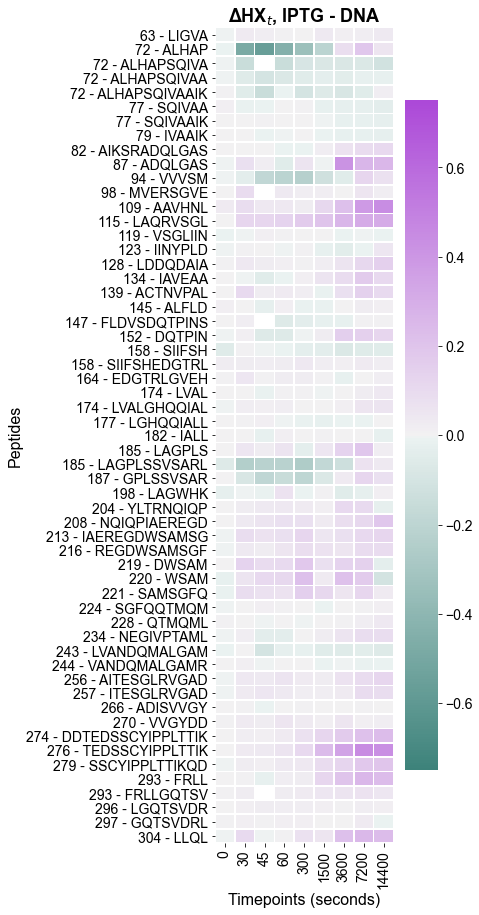

In [219]:
diff_states_list = []
for state in possible_states:
    if state.value == True:
        diff_states_list.append(state)

if len(diff_states_list) != 2:
    print('Please choose exactly two states from the list above.')
    
else:
    import re
    found_states = []
    for state in diff_states_list:
        state = str(state)
        m = re.search("'(.+?)'", state)
        found_states.append(m.group(1))      

# create dictionary for deuteration differences at all HDX tps

dDt_tps_dict = {}
dDS_dict = {}
dDbar_dict = {}

for peptide in peptide_exchange_dict:
    dDt_tps = []
    for element in peptide_exchange_dict.get(peptide):
        for key in element:
            if key in found_states:
                dDt_tps.append(np.array(element.get(key)))
                
    # calculate dDS - sum dDt    
    dDS = (dDt_tps[0] - dDt_tps[1])
    n_T = len(dDS) # number of distinct HX labeling times for the peptide, discounting NaNs
    dDS_dict[peptide] = sum(dDS) # deuteration difference summed over all HX times, no NaNs
    dDbar_dict[peptide] = sum(dDS)/n_T # arithmetic mean deuteration difference across all HX times, no NaNs
                
    # calculate dHXt - dDt/(N_H * m_d)
    dDt_tps = (dDt_tps[0] - dDt_tps[1])/(len(peptide) - 2 - peptide[2:].count('P'))
#     dDt_tps = (dDt_tps[0] - dDt_tps[1]) # for non-normalized to total exchangeable protons

    dDt_tps_dict[peptide] = dDt_tps
        
# generating lists for heatmap
heatmap_timepoints = timepoints * 57

heatmap_peptides = []
for peptide in all_peptides_2:
    temp_peptides = []
    temp_peptides.append(peptide)
    temp_peptides = temp_peptides * 9
    heatmap_peptides.append(temp_peptides)
    flat_list = []
    for sublist in heatmap_peptides:
        for item in sublist:
            flat_list.append(item)

heatmap_values = []
for dDt_tp in dDt_tps_dict.values():
    for tp in dDt_tp:
        heatmap_values.append(tp)

heatmap_df = pd.DataFrame({'Timepoints (seconds)': heatmap_timepoints, 'Peptides': flat_list, 
                           'Sensitivity': heatmap_values })
# plot it

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14
       }
axes = {'titlesize' : 18,
        'titleweight' : 'bold',
        'labelsize' : 16
       }

plt.rc('font', **font)
plt.rc('axes', **axes)

plt.rcParams['figure.figsize'] = (4, 15)
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Arial'

df_wide=heatmap_df.pivot_table( index='Peptides', columns='Timepoints (seconds)', values='Sensitivity' )
df_wide.index = pd.CategoricalIndex(df_wide.index, categories = all_peptides_2)
df_wide.sort_index(level=0, inplace=True)

cmap = sns.diverging_palette(180, 290, as_cmap=True)

p2 = sns.heatmap( df_wide, cmap=cmap, linewidths=.75, vmin=-.75, vmax=.75)
# p2 = sns.heatmap( df_wide, cmap=cmap, linewidths=.75, vmin=-6, vmax=6) # for non-normalized
p2.set_title("\u0394HX$_{t}$, " + found_states[0] + ' - ' + found_states[1])
plt.savefig('dHXt_' + found_states[0] + '_' + found_states[1] + '.png', bbox_inches="tight")

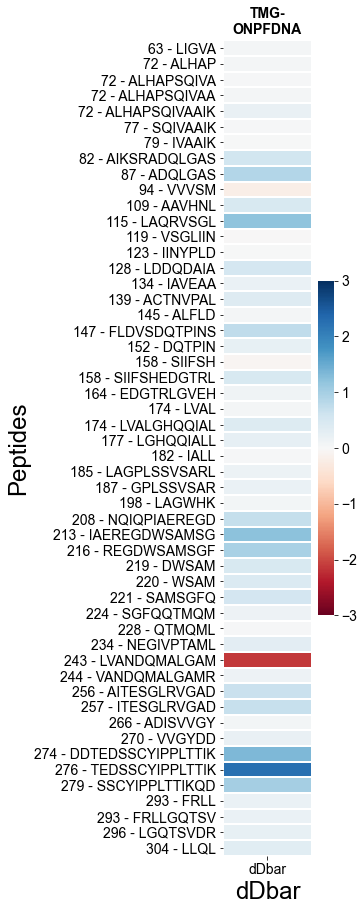

In [151]:
dDbar_heatmap_df = pd.DataFrame({'dDbar': 'dDbar', 'Peptides': all_peptides_2, 
                           'Sensitivity': dDbar_dict.values() })
# plot it

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14
       }
axes = {'titlesize' : 14,
        'titleweight' : 'bold',
        'labelsize' : 24
       }

plt.rc('font', **font)
plt.rc('axes', **axes)

plt.rcParams['figure.figsize'] = (2, 15)
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Arial'

dDbar_df_wide = dDbar_heatmap_df.pivot_table( index='Peptides', columns='dDbar', values='Sensitivity' )
dDbar_df_wide.index = pd.CategoricalIndex(dDbar_df_wide.index, categories = all_peptides_2)
dDbar_df_wide.sort_index(level=0, inplace=True)

p2 = sns.heatmap( dDbar_df_wide, cmap="RdBu", linewidths = 1, vmin = -3, vmax = 3)
p2.set_title(found_states[0] + '-\n' + found_states[1])
plt.savefig('dDbar_plots/dDbar_' + found_states[0] + '_' + found_states[1] + '.png', bbox_inches="tight")

### Graph exchange parameters against each other for selected states.

In [ ]:
            
# for key in peptide_params_dict.keys():
#     print(key)
#     print(len(peptide_params_dict.get(key)))
#     print(peptide_params_dict.get(key)[0])
#     print(peptide_params_dict.get(key)[1])
#     print(peptide_params_dict.get(key)[2])
#     for x in peptide_params_dict.get(key)[2].values():
#         for y in x:
#             print(y)

compare_med_dict = {}
for [peptide] in all_peptides:
    compare_med_dict[peptide] = []
    
compare_med_dict_ = {}
for [peptide] in all_peptides:
    compare_med_dict_[peptide] = []

state1 = str(peptide_params_dict.get(peptide)[0].keys())
state1 = state1[12:-3]
print(state1)

state2 = str(peptide_params_dict.get(peptide)[1].keys())
state2 = state2[12:-3]
print(state2)

state3 = str(peptide_params_dict.get(peptide)[2].keys())
state3 = state3[12:-3]
print(state3)

#     return max_protons - a * np.exp(-d * x) - b * np.exp(-e * x) - c * np.exp(-f * x) - g
#     return max_protons - b * np.exp(-e * x) - c * np.exp(-f * x) - g

for peptide in peptide_params_dict.keys():
    state1_params = []
    for x in peptide_params_dict.get(peptide)[0].values(): 
        for y in x:
            state1_params.append(y)
    if len(state1_params) > 5:
        state1_med = (state1_params[1]*state1_params[4]) + (state1_params[2]*state1_params[5])
    else:
        state1_med = (state1_params[0]*state1_params[3]) + (state1_params[1]*state1_params[4])
    
    state2_params = []
    for x in peptide_params_dict.get(peptide)[1].values(): 
        for y in x:
            state2_params.append(y)
    if len(state2_params) > 5:
        state2_med = (state2_params[1]*state2_params[4]) + (state2_params[2]*state2_params[5])
    else:
        state2_med = (state2_params[0]*state2_params[3]) + (state2_params[1]*state2_params[4])
        
    state3_params = []
    for x in peptide_params_dict.get(peptide)[2].values(): 
        for y in x:
            state3_params.append(y)
    if len(state3_params) > 5:
        state3_med = (state3_params[1]*state3_params[4]) + (state3_params[2]*state3_params[5])
    else:
        state3_med = (state3_params[0]*state3_params[3]) + (state3_params[1]*state3_params[4])
        
    temp_tuple = (state1_med, state2_med)
    compare_med_dict[peptide] = temp_tuple
    
    temp_tuple_ = (state2_med, state3_med)
    compare_med_dict_[peptide] = temp_tuple_

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 18
       }
axes = {'titlesize' : 24,
        'titleweight' : 'bold',
        'labelsize' : 24
       }

plt.rc('font', **font)
plt.rc('axes', **axes)
plt.rc('lines', lw = 3)
    
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

for key in compare_med_dict:
    ax1.plot(compare_med_dict.get(key)[0], compare_med_dict.get(key)[1], 'o', markersize = 10 )
#     ax1.annotate(key, (compare_med_dict.get(key)[0], compare_med_dict.get(key)[1]), font = 'Arial', fontsize = 10)
for key in compare_med_dict_:
    ax2.plot(compare_med_dict_.get(key)[1], compare_med_dict_.get(key)[0], 'o', markersize = 10)
#     ax2.annotate(key, (compare_med_dict_.get(key)[1], compare_med_dict_.get(key)[0]), font = 'Arial', fontsize = 10)
    
ax1.set_ylabel(state2)
ax1.set_xlabel(state1)
ax2.set_ylabel(state2)
ax2.set_xlabel(state3)
# ax1.set_title(str(peptide1_first_res) + ' - ' + peptide_input1)
# ax2.set_title(str(peptide2_first_res) + ' - ' + peptide_input2)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax1.set_ylim(.00001, 10)
ax2.set_ylim(.00001, 10)
ax1.set_xlim(.00001, 10)
ax2.set_xlim(.00001, 10)
# ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

In [ ]:
row_labels = []
PCA_df = pd.DataFrame()

for peptide in peptide_fit_dict:
    temp = peptide_fit_dict.get(peptide)
    for list_item in temp:
        state_label = str(list_item.keys())[12:-3]
        row_label = peptide + '_' + state_label
        row_labels.append(row_label)

        temp_df = pd.DataFrame(list_item.get(state_label))
        temp_df = temp_df.transpose()
        PCA_df = PCA_df.append(temp_df)

y_list = []
z_list = []       
for row_label in row_labels:
    y_list.append(row_label.split('_')[0])
    z_list.append(row_label.split('_')[1])
    
y_df = pd.DataFrame(y_list) # peptide matrix
z_df = pd.DataFrame(z_list) # state matrix

from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(PCA_df)

from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components = 2, svd_solver = 'full')
Y_sklearn = sklearn_pca.fit_transform(X_std)

print('explained variance ratio: ' + str(sklearn_pca.explained_variance_ratio_))
print('total Variance Explained:', round(sum(list(sklearn_pca.explained_variance_ratio_))*100, 2))
print('singular values: ' + str(sklearn_pca.singular_values_))

# Create a new dataset from principal components 
df = pd.DataFrame(data = Y_sklearn, columns = ['PC1', 'PC2'])

result_df = pd.concat([df, y_df, z_df], axis=1)
result_df.columns =['PC1', 'PC2', 'peptide', 'state']

# Visualize Principal Components with a scatter plot
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('First Principal Component ', fontsize = 20)
ax.set_ylabel('Second Principal Component ', fontsize = 20)
ax.set_title('Principal Component Analysis (2PCs) for HDX Dataset', fontsize = 20)

color_dict = {
    'IPTG' : 'blue',
    'ONPF' : 'orange',
    'APO' : 'green',
    'DNA' : 'red',
    'TMG' : 'gray',
    'ONPFDNA' : 'purple'}

shape_dict = {
    'IPTG' : 'o',
    'ONPF' : 's',
    'APO' : '+',
    'DNA' : '^',
    'TMG' : 'd',
    'ONPFDNA' : '1'}


# color_dict = {
# 'LIGVA' : 'rosybrown',
# 'ALHAP' : 'lightcoral',
# 'ALHAPSQIVA': 'brown',
# 'ALHAPSQIVAA' : 'maroon',
# 'ALHAPSQIVAAIK' : 'red',
# 'SQIVAA' : 'tomato',
# 'SQIVAAIK' : 'sienna',
# 'IVAAIK' : 'saddlebrown',
# 'AIKSRADQLGAS': 'sandybrown',
# 'ADQLGAS': 'peru',
# 'VVVSM': 'bisque',
# 'MVERSGVE' : 'darkorange',
# 'AAVHNL' : 'navajowhite',
# 'LAQRVSGL' : 'orange',
# 'VSGLIIN' : 'darkgoldenrod',
# 'IINYPLD' : 'gold',
# 'LDDQDAIA' : 'lemonchiffon',
# 'IAVEAA' : 'darkkhaki',
# 'ACTNVPAL' : 'olive',
# 'ALFLD' : 'yellow',
# 'FLDVSDQTPINS' : 'olivedrab',
# 'DQTPIN' : 'yellowgreen',
# 'SIIFSH' : 'greenyellow',
# 'SIIFSHEDGTRL' : 'darkseagreen',
# 'EDGTRLGVEH' : 'palegreen',
# 'LVAL' : 'forestgreen',
# 'LVALGHQQIAL' : 'limegreen',
# 'LGHQQIALL' : 'green',
# 'IALL' : 'mediumaquamarine',
# 'LAGPLS' : 'turquoise',
# 'LAGPLSSVSARL' : 'paleturquoise',
# 'GPLSSVSAR' : 'teal',
# 'LAGWHK' : 'aqua',
# 'YLTRNQIQP': 'lightblue',
# 'NQIQPIAEREGD' : 'deepskyblue',
# 'IAEREGDWSAMSG' : 'steelblue',
# 'REGDWSAMSGF' : 'slategray',
# 'DWSAM' : 'royalblue',
# 'WSAM' : 'blue',
# 'SAMSGFQ' : 'darkslateblue',
# 'SGFQQTMQM' : 'mediumpurple',
# 'QTMQML' : 'rebeccapurple',
# 'NEGIVPTAML' : 'darkorchid',
# 'LVANDQMALGAM' : 'thistle',
# 'VANDQMALGAMR' : 'violet',
# 'AITESGLRVGAD' : 'fuchsia',
# 'ITESGLRVGAD' : 'mediumvioletred',
# 'ADISVVGY' : 'deeppink',
# 'VVGYDD' : 'crimson',
# 'DDTEDSSCYIPPLTTIK' : 'dimgray',
# 'TEDSSCYIPPLTTIK' : 'darkgray',
# 'SSCYIPPLTTIKQD' : 'lightgray',
# 'FRLL' : 'beige',
# 'FRLLGQTSV' : 'pink',
# 'LGQTSVDR' : 'aliceblue',
# 'GQTSVDRL' : 'wheat',
# 'LLQL' : 'cornsilk'
# }

states = list(set(z_list))
peptides = list(set(y_list))

i = 0
while i < 171:
    result_df_ = result_df.iloc[i]
    state_ = result_df_['state']
    peptide_ = result_df_['peptide']
    ax.scatter(result_df_['PC1'], result_df_['PC2'], 
               color = color_dict.get(state_),
               marker = shape_dict.get(state_), 
               s = 100, 
               edgecolors = 'k')
#     ax.annotate(peptide_, (result_df_['PC1'], result_df_['PC2']), font = 'Arial', fontsize = 7)
    i = i + 1
            
# ax.set_ylim(-40,40)
# ax.set_xlim(-120,100)
# ax.legend(shape_dict.keys())
ax.grid()

In [ ]:
row_labels = []
PCA_df = pd.DataFrame()

for peptide in peptide_params_dict:
    temp = peptide_params_dict.get(peptide)
    for list_item in temp:
        state_label = str(list_item.keys())[12:-3]
        if len(list_item.get(state_label)) > 6:
            temp_df = pd.DataFrame(list_item.get(state_label))
            temp_df = temp_df.transpose()
            PCA_df = PCA_df.append(temp_df)
            row_label = peptide + '_' + state_label
            row_labels.append(row_label)


            
y_list = []
z_list = []       
for row_label in row_labels:
    y_list.append(row_label.split('_')[0])
    z_list.append(row_label.split('_')[1])
    
y_df = pd.DataFrame(y_list) # peptide matrix
z_df = pd.DataFrame(z_list) # state matrix

from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(PCA_df)

from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components = 2, svd_solver = 'full')
Y_sklearn = sklearn_pca.fit_transform(X_std)

print('explained variance ratio: ' + str(sklearn_pca.explained_variance_ratio_))
print('total Variance Explained:', round(sum(list(sklearn_pca.explained_variance_ratio_))*100, 2))
print('singular values: ' + str(sklearn_pca.singular_values_))

# Create a new dataset from principal components 
df = pd.DataFrame(data = Y_sklearn, columns = ['PC1', 'PC2'])

result_df = pd.concat([df, y_df, z_df], axis=1)
result_df.columns =['PC1', 'PC2', 'peptide', 'state']

# Visualize Principal Components with a scatter plot
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('First Principal Component ', fontsize = 20)
ax.set_ylabel('Second Principal Component ', fontsize = 20)
ax.set_title('Principal Component Analysis (2PCs) for HDX Dataset', fontsize = 20)

# color_dict = {
#     'IPTG' : 'blue',
#     'ONPF' : 'orange',
#     'APO' : 'green',
#     'DNA' : 'red',
#     'TMG' : 'gray',
#     'ONPFDNA' : 'purple'}

shape_dict = {
    'IPTG' : 'o',
    'ONPF' : 's',
    'APO' : '+',
    'DNA' : '^',
    'TMG' : 'd',
    'ONPFDNA' : '1'}

color_dict = {
'LIGVA' : 'rosybrown',
'ALHAP' : 'lightcoral',
'ALHAPSQIVA': 'brown',
'ALHAPSQIVAA' : 'maroon',
'ALHAPSQIVAAIK' : 'red',
'SQIVAA' : 'tomato',
'SQIVAAIK' : 'sienna',
'IVAAIK' : 'saddlebrown',
'AIKSRADQLGAS': 'sandybrown',
'ADQLGAS': 'peru',
'VVVSM': 'bisque',
'MVERSGVE' : 'darkorange',
'AAVHNL' : 'navajowhite',
'LAQRVSGL' : 'orange',
'VSGLIIN' : 'darkgoldenrod',
'IINYPLD' : 'gold',
'LDDQDAIA' : 'lemonchiffon',
'IAVEAA' : 'darkkhaki',
'ACTNVPAL' : 'olive',
'ALFLD' : 'yellow',
'FLDVSDQTPINS' : 'olivedrab',
'DQTPIN' : 'yellowgreen',
'SIIFSH' : 'greenyellow',
'SIIFSHEDGTRL' : 'darkseagreen',
'EDGTRLGVEH' : 'palegreen',
'LVAL' : 'forestgreen',
'LVALGHQQIAL' : 'limegreen',
'LGHQQIALL' : 'green',
'IALL' : 'mediumaquamarine',
'LAGPLS' : 'turquoise',
'LAGPLSSVSARL' : 'paleturquoise',
'GPLSSVSAR' : 'teal',
'LAGWHK' : 'aqua',
'YLTRNQIQP': 'lightblue',
'NQIQPIAEREGD' : 'deepskyblue',
'IAEREGDWSAMSG' : 'steelblue',
'REGDWSAMSGF' : 'slategray',
'DWSAM' : 'royalblue',
'WSAM' : 'blue',
'SAMSGFQ' : 'darkslateblue',
'SGFQQTMQM' : 'mediumpurple',
'QTMQML' : 'rebeccapurple',
'NEGIVPTAML' : 'darkorchid',
'LVANDQMALGAM' : 'thistle',
'VANDQMALGAMR' : 'violet',
'AITESGLRVGAD' : 'fuchsia',
'ITESGLRVGAD' : 'mediumvioletred',
'ADISVVGY' : 'deeppink',
'VVGYDD' : 'crimson',
'DDTEDSSCYIPPLTTIK' : 'dimgray',
'TEDSSCYIPPLTTIK' : 'darkgray',
'SSCYIPPLTTIKQD' : 'lightgray',
'FRLL' : 'beige',
'FRLLGQTSV' : 'pink',
'LGQTSVDR' : 'aliceblue',
'GQTSVDRL' : 'wheat',
'LLQL' : 'cornsilk'
}

states = list(set(z_list))
peptides = list(set(y_list))

i = 0
while i < len(row_labels):
    result_df_ = result_df.iloc[i]
    state_ = result_df_['state']
    peptide_ = result_df_['peptide']
    ax.scatter(result_df_['PC1'], result_df_['PC2'], 
               color = color_dict.get(peptide_),
               marker = shape_dict.get(state_), 
               s = 100)
#     ax.annotate(peptide_, (result_df_['PC1'], result_df_['PC2']), font = 'Arial', fontsize = 7)
    i = i + 1
            
# ax.set_ylim(-40,40)
# ax.set_xlim(-120,100)
ax.legend(shape_dict.keys())
ax.grid()